In [91]:
import skimage as sk
import matplotlib.pyplot as plt
import napari
import numpy as np
from cellpose import models, io
from copy import copy
import cv2

In [2]:
image = sk.io.imread('./domes/domes_n2v/70_denoised.tif')

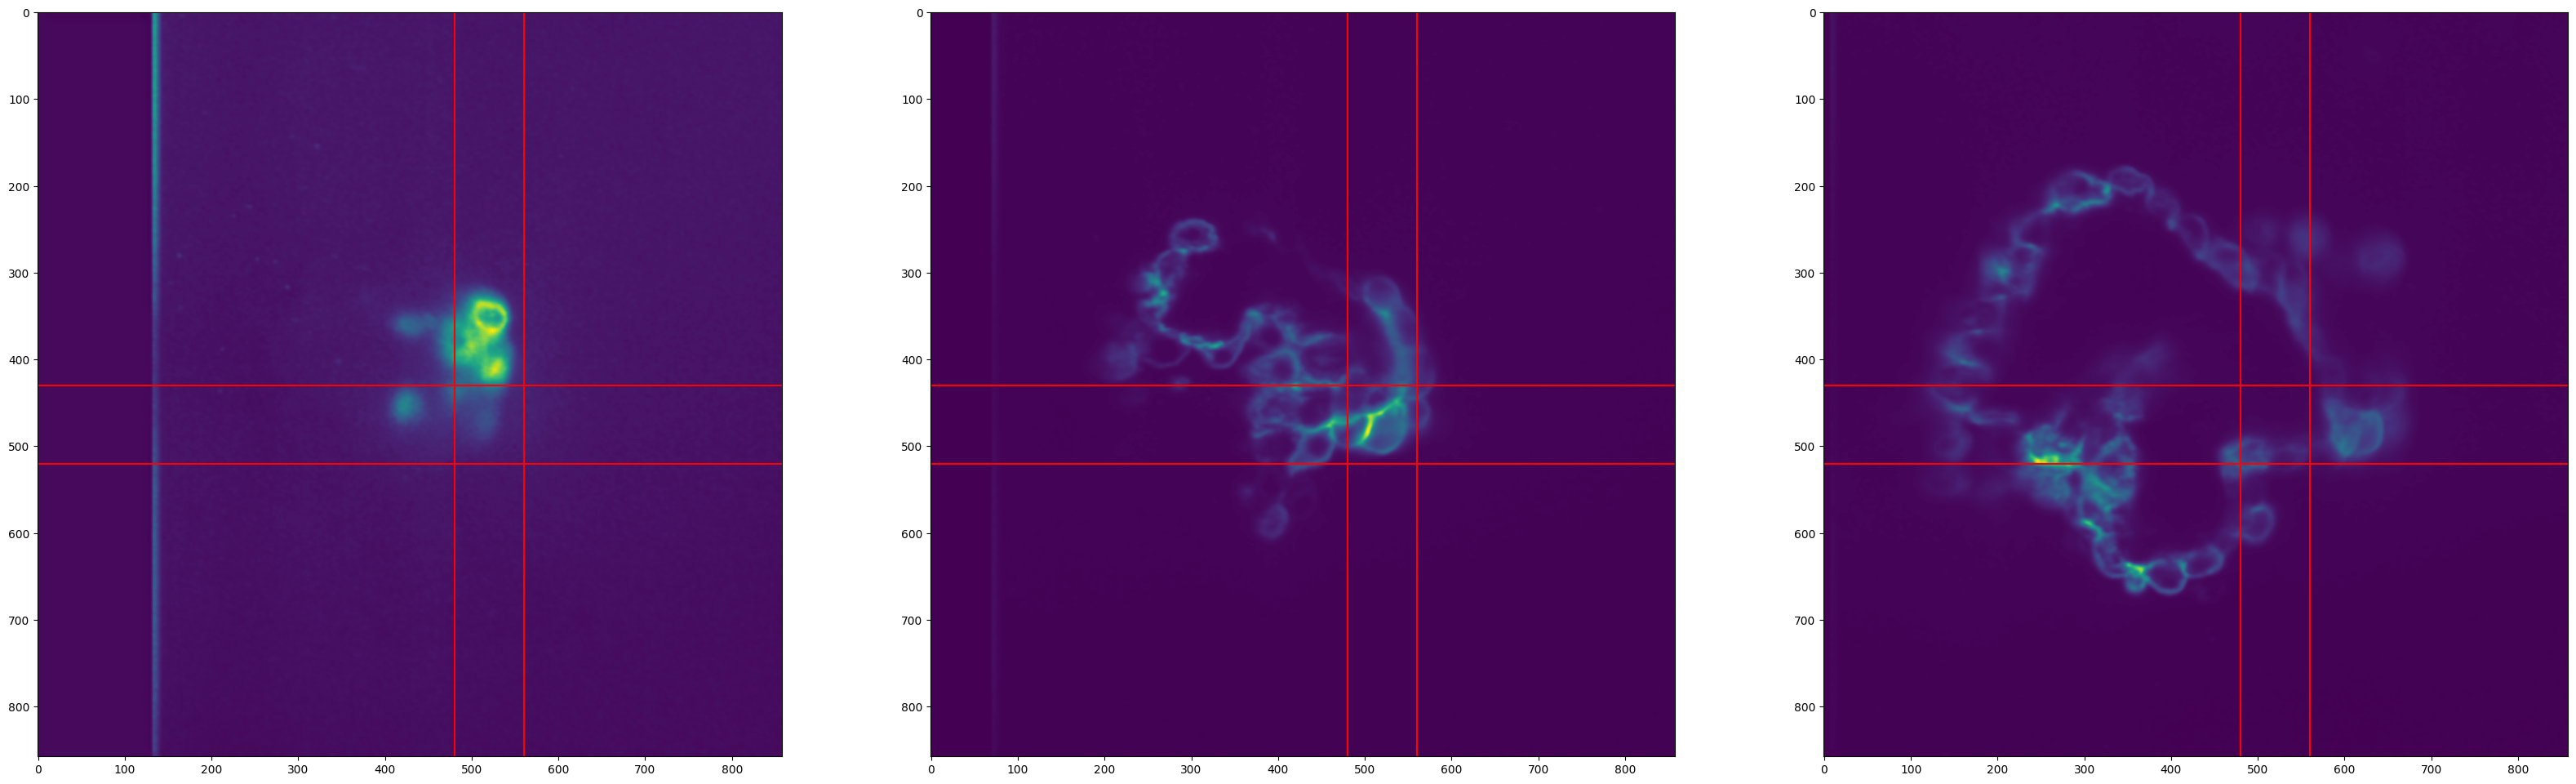

In [185]:
t = 3

z1 = 310
z2 = 385
y1 = 380
y2 = 480
x1 = 250
x2 = 330


z1 = 260
z2 = 385
y1 = 430
y2 = 520
x1 = 480
x2 = 560

z1_5 = int(np.array([z1, z2]).mean())

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image[t][z1])
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')

plt.subplot(1,3,2)
plt.imshow(image[t][z1_5])
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')

plt.subplot(1,3,3)
plt.imshow(image[t][z2])
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')

In [186]:
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0] # There is no nucleus, the image is GRAYSCALE. First number would be the channel for the cytoplasm and the second for the nucleus

In [187]:
im = image[t][z1:z2, y1:y2, x1:x2]

masks, flows, styles, diams = model.eval(im, channels=channels, diameter=None, do_3D=True)

could not estimate diameter, does not work on non-2D images


1


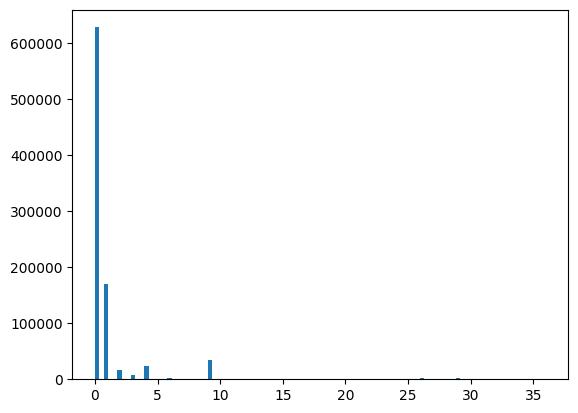

In [189]:
plt.hist(masks.flatten(), bins=100)

unique_values, counts = np.unique(masks.flatten(), return_counts=True)

# Print or use the results as needed
# for value, count in zip(unique_values, counts):
#     print(f"Value {value} repeats {count} times.")

m = 1

mask = copy(masks)

mask[masks == m] = 1
mask[masks != m] = 0

print(mask.max())


In [190]:
from skimage.morphology import ball, binary_opening, skeletonize_3d
from skimage import morphology

selem = ball(radius=3)

t_mask = binary_opening(mask, selem) # This is a rounder mask. It does not have random pixels nor strange shape

s_mask = skeletonize_3d(t_mask) # This is 3D skeleton of the cell. It is like the bone of the cell in the center

border_mask = np.logical_xor(t_mask, morphology.binary_erosion(t_mask)) # This is just the border of the mask

mask_on_image = t_mask*im # This is the image in the mask


In [180]:
# Foreach border_mask point compute which of the s_maks (skeletonized) point makes the distance be minimum, and then compute the distance and direction
border_points = np.argwhere(border_mask) # Get the coordinates of the border
skeleton_points = np.argwhere(s_mask) # Get the coordinates of the skeleton

smaller_border = np.zeros(border_mask.shape)
print(smaller_border.shape)

def find_closest_point(reference_point, array_of_points):
    '''
    This function returns the closest point to a given point of a bunch of points
    '''
    distances = np.linalg.norm(array_of_points - reference_point, axis=1) # Coumpute all the distances
    min_distance_index = np.argmin(distances) # Get the minimum distance of all the distances
    closest_point = array_of_points[min_distance_index] # Get the point which has the lowes distance
    return closest_point, distances[min_distance_index]

for point in border_points:
    closest, min_dist = find_closest_point(point, skeleton_points) # Get the closest point and the distance given a point
    direction = closest - point # Direction of the distance
    normalized_direction = direction / np.linalg.norm(direction) # Normalized direction
    # print(point, closest, min_dist, direction, normalized_direction)
    
    current_point = tuple(point)
    inner_point_list = point+normalized_direction*1
    inner_point = tuple(np.round(inner_point_list).astype(int))
    
    c = 2 
    
    while mask_on_image[inner_point] > mask_on_image[current_point] and c < 15:
        
        current_point = inner_point
        inner_point_list = current_point+normalized_direction*c # Elongate the vector to get the inner point
        inner_point = tuple(np.round(inner_point_list).astype(int))
        c += 1
        
        # print(current_point, inner_point)
        
    smaller_border[inner_point] = 1

(75, 100, 80)


In [ ]:
# Compute windows of surface, find the tangent and the normal to this tangent. Find if the normal contains brighter pixels on its direction

In [191]:
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(mask)
viewer.add_image(t_mask)
viewer.add_image(mask_on_image)
viewer.add_image(s_mask)
viewer.add_image(border_mask)
# viewer.add_image(smaller_border)

<Image layer 'border_mask' at 0x268d8b42ad0>

In [192]:
masks2, flows2, styles2, diams2 = model.eval(mask_on_image, channels=channels, diameter=None, do_3D=True)

could not estimate diameter, does not work on non-2D images


<Image layer 'masks2' at 0x268def5db50>

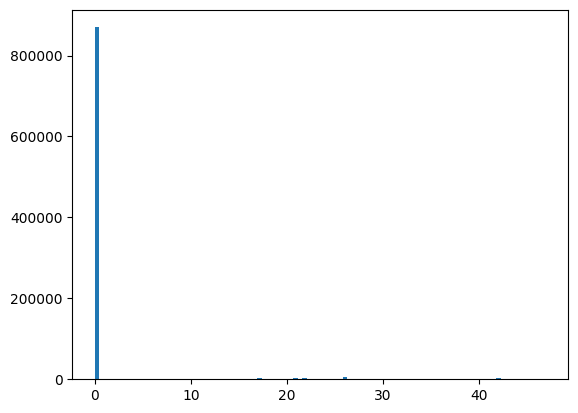

In [193]:
plt.hist(masks2.flatten(), bins=100)
viewer.add_image(masks2)